# Breast Cancer Detection Model Ver01

## 0. Import Module

- [OpenSlide](https://openslide.org/api/python/#module-openslide)

In [1]:
%matplotlib inline
import os
import csv
import cv2
import openslide
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from skimage.filters import threshold_otsu
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from openslide.deepzoom import DeepZoomGenerator

## 1. Data Load

In [2]:
# slide path
slide_path = '../data/train/pos/16-S-042893_A1.mrxs'  # pos
# neg_slide_path = '../data/train/16-S-042725_A.mrxs'  # neg

# mask path
truth_path = '../data/train/pos/Mask_16-S-042893_A1.png'  # pos
# neg_mask_path = '../data/train/Mask_16-S-042725_A.png'  # neg

# openslide
## slide
slide = openslide.open_slide(slide_path)
# neg_slide = openslide.open_slide(neg_slide_path)
## mask
truth = openslide.open_slide(truth_path)
# neg_mask = openslide.open_slide(neg_mask_path)

In [3]:
print('origin slide.dimensions :', slide.dimensions)
# print('origin neg_slide.dimensions :', neg_slide.dimensions)
print('origin truth.dimensions :', truth.dimensions)
# print('origin neg_mask.dimensions :', neg_mask.dimensions)

origin slide.dimensions : (93970, 234042)
origin truth.dimensions : (5316, 10007)


## 2. Patch Gen

### 1) Find Patches from Slide

In [5]:
patch_size = 256
is_train = True

# 해당 데이터가 양성인지 판단
slide_contains_tumor = 'pos' in slide_path

# read_region을 위한 start, level, size 계산
bounds_offset_props = (openslide.PROPERTY_NAME_BOUNDS_X, openslide.PROPERTY_NAME_BOUNDS_Y)
bounds_size_props = (openslide.PROPERTY_NAME_BOUNDS_WIDTH, openslide.PROPERTY_NAME_BOUNDS_HEIGHT)

with openslide.open_slide(slide_path) as slide:
    start = (int(slide.properties.get(bounds_offset_props[0], 0)), 
             int(slide.properties.get(bounds_offset_props[1], 0)))
    level = int(np.log2(patch_size))
    
    size_scale = tuple(int(slide.properties.get(prop, dim)) / dim 
                       for prop, dim in zip(bounds_size_props, slide.dimensions))
    l_dimensions = [(int(np.ceil(dim_x * size_scale[0])), int(np.ceil(dim_y * size_scale[1])))
                    for dim_x, dim_y in slide.level_dimensions]
    size = l_dimensions[level]
    
    slide4 = slide.read_region(start, level, size)

In [6]:
# is_tissue 부분
slide4_grey = np.array(slide4.convert('L'))

# background에 대한 작업
slide4_not_black = slide4_grey[slide4_grey > 0]
# thresh = threshold_otsu(slide4_not_black)
ret, th = cv2.threshold(slide4_not_black, 0, 255, 
                        cv2.THRESH_BINARY+cv2.THRESH_OTSU)

binary = slide4_grey > 0  # black == 0
h, w = slide4_grey.shape
for i in range(h):
    for j in range(w):
        if slide4_grey[i, j] > ret:
            binary[i, j] = False
            
# patch_df
patches = pd.DataFrame(pd.DataFrame(binary).stack(), columns=['is_tissue'])
patches['slide_path'] = slide_path
patches.head()

is_tissue                             slide_path
0 0      False  ../data/train/pos/16-S-042893_A1.mrxs
  1      False  ../data/train/pos/16-S-042893_A1.mrxs
  2      False  ../data/train/pos/16-S-042893_A1.mrxs
  3      False  ../data/train/pos/16-S-042893_A1.mrxs
  4      False  ../data/train/pos/16-S-042893_A1.mrxs

In [7]:
# is_tumor 부분
if slide_contains_tumor:
    with openslide.open_slide(truth_path) as truth:
        thumbnail_truth = truth.get_thumbnail(size)
        
    # truth pathes_df
    patches_y = pd.DataFrame(
            pd.DataFrame(np.array(thumbnail_truth.convert('L'))).stack())
    patches_y['is_tumor'] = patches_y[0] > 0
    
    # mask된 영역이 애매한 경우
    patches_y['is_all_tumor'] = patches_y[0] == 255
    patches_y.drop(0, axis=1, inplace=True)
    samples = pd.concat([patches, patches_y], axis=1)
else: 
    samples = patches
    samples['is_tumor'] = False

samples.head()

is_tissue                             slide_path  is_tumor  is_all_tumor
0 0      False  ../data/train/pos/16-S-042893_A1.mrxs     False         False
  1      False  ../data/train/pos/16-S-042893_A1.mrxs     False         False
  2      False  ../data/train/pos/16-S-042893_A1.mrxs     False         False
  3      False  ../data/train/pos/16-S-042893_A1.mrxs     False         False
  4      False  ../data/train/pos/16-S-042893_A1.mrxs     False         False

In [8]:
filter_non_tissue = True
if filter_non_tissue:  # tissue인것만 가져오기
    samples = samples[samples.is_tissue == True]
    
samples.head()

is_tissue                             slide_path  is_tumor  \
17 165       True  ../data/train/pos/16-S-042893_A1.mrxs     False   
   166       True  ../data/train/pos/16-S-042893_A1.mrxs     False   
   167       True  ../data/train/pos/16-S-042893_A1.mrxs     False   
   201       True  ../data/train/pos/16-S-042893_A1.mrxs     False   
   205       True  ../data/train/pos/16-S-042893_A1.mrxs     False   

        is_all_tumor  
17 165         False  
   166         False  
   167         False  
   201         False  
   205         False

In [9]:
filter_only_all_tumor = True

samples['tile_loc'] = list(samples.index)
all_tissue_samples = samples[samples['is_tumor'] == False]
all_tissue_samples = all_tissue_samples.append(samples[samples['is_all_tumor'] == True])
all_tissue_samples.head()

is_tissue                             slide_path  is_tumor  \
17 165       True  ../data/train/pos/16-S-042893_A1.mrxs     False   
   166       True  ../data/train/pos/16-S-042893_A1.mrxs     False   
   167       True  ../data/train/pos/16-S-042893_A1.mrxs     False   
   201       True  ../data/train/pos/16-S-042893_A1.mrxs     False   
   205       True  ../data/train/pos/16-S-042893_A1.mrxs     False   

        is_all_tumor   tile_loc  
17 165         False  (17, 165)  
   166         False  (17, 166)  
   167         False  (17, 167)  
   201         False  (17, 201)  
   205         False  (17, 205)

In [10]:
all_tissue_samples['is_tumor'].value_counts()

False    74490
True     30723
Name: is_tumor, dtype: int64

### 2) Create function

In [4]:
def find_patches_from_slide(slide_path, 
                            truth_path, 
                            patch_size=256, 
                            filter_non_tissue=True):
    '''Returns a DataFrame of all patches in slide
        Args:
            - slide_path: path of slide
            - truth_path: path of truth(mask)
            - patch_size: patch size for samples
            - filter_non_tissue: remove samples no tissue detected
        Returns:
            - all_tissue_samples: patch samples from slide'''
    # 해당 데이터가 양성인지 판단
    slide_contains_tumor = 'pos' in slide_path

    # read_region을 위한 start, level, size 계산
    bounds_offset_props = (openslide.PROPERTY_NAME_BOUNDS_X, openslide.PROPERTY_NAME_BOUNDS_Y)
    bounds_size_props = (openslide.PROPERTY_NAME_BOUNDS_WIDTH, openslide.PROPERTY_NAME_BOUNDS_HEIGHT)

    with openslide.open_slide(slide_path) as slide:
        start = (int(slide.properties.get(bounds_offset_props[0], 0)), 
                 int(slide.properties.get(bounds_offset_props[1], 0)))
        level = int(np.log2(patch_size))

        size_scale = tuple(int(slide.properties.get(prop, dim)) / dim 
                           for prop, dim in zip(bounds_size_props, slide.dimensions))
        l_dimensions = [(int(np.ceil(dim_x * size_scale[0])), int(np.ceil(dim_y * size_scale[1])))
                        for dim_x, dim_y in slide.level_dimensions]
        size = l_dimensions[level]

        slide4 = slide.read_region(start, level, size)
        
    # is_tissue 부분
    slide4_grey = np.array(slide4.convert('L'))

    # background에 대한 작업
    slide4_not_black = slide4_grey[slide4_grey > 0]
    # thresh = threshold_otsu(slide4_not_black)
    ret, th = cv2.threshold(slide4_not_black, 0, 255, 
                            cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    binary = slide4_grey > 0  # black == 0
    h, w = slide4_grey.shape
    for i in range(h):
        for j in range(w):
            if slide4_grey[i, j] > ret:
                binary[i, j] = False

    # patch_df
    patches = pd.DataFrame(pd.DataFrame(binary).stack(), columns=['is_tissue'])
    patches['slide_path'] = slide_path
    
    # is_tumor 부분
    if slide_contains_tumor:
        with openslide.open_slide(truth_path) as truth:
            thumbnail_truth = truth.get_thumbnail(size)

        # truth pathes_df
        patches_y = pd.DataFrame(
                pd.DataFrame(np.array(thumbnail_truth.convert('L'))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0

        # mask된 영역이 애매한 경우
        patches_y['is_all_tumor'] = patches_y[0] == 255
        patches_y.drop(0, axis=1, inplace=True)
        samples = pd.concat([patches, patches_y], axis=1)
    else: 
        samples = patches
        samples['is_tumor'] = False

    if filter_non_tissue:  # tissue인것만 가져오기
        samples = samples[samples.is_tissue == True]

    samples['tile_loc'] = list(samples.index)
    all_tissue_samples = samples[samples['is_tumor'] == False]
    all_tissue_samples = all_tissue_samples.append(samples[samples['is_all_tumor'] == True])
    return all_tissue_samples

In [5]:
%%time
all_tissue_samples = find_patches_from_slide(slide_path, truth_path)

CPU times: user 1.35 s, sys: 68 ms, total: 1.42 s
Wall time: 1.43 s


In [6]:
all_tissue_samples['is_tumor'].value_counts()

False    74490
True     30723
Name: is_tumor, dtype: int64

## 3. Train data Gen

### 1) Create Train Dataset

In [7]:
# Set Params
patch_size = 256
batch_size = 100
shuffle = False
samples = all_tissue_samples.sample(1000, random_state=13)

In [10]:
# slide path
slide_path = '../data/train/pos/16-S-042893_A1.mrxs'  # pos
slide = openslide.open_slide(slide_path)

# tiles
tiles = DeepZoomGenerator(slide, tile_size=patch_size, 
                          overlap=0, limit_bounds=False)

start_x = int(slide.properties.get('openslide.bounds-x', 0)) / patch_size
start_y = int(slide.properties.get('openslide.bounds-y', 0)) / patch_size

In [16]:
num_samples = len(samples)
slide_contains_tumor = 'pos' in slide_path
if slide_contains_tumor:
    truth = openslide.open_slide(truth_path)
    truth_tiles = DeepZoomGenerator(truth, tile_size=16,  # tile_size=16인 이유는 mask가 원본의 1/16이어서 그런가?
                                    overlap=0, limit_bounds=False)
    
if shuffle:
    samples = samples.sample(frac=1)  # shuffling

for offset in range(0, num_samples, batch_size):
    batch_samples = samples.iloc[offset:offset+batch_size]
    
    batch_tiles, batch_masks = [], []
    for y, x in batch_samples['tile_loc'].values:
        img = tiles.get_tile(tiles.level_count-1, (x+start_x, y+start_y))
        batch_tiles.append(np.array(img, dtype=int))

        mask_tile = truth_tiles.get_tile(truth_tiles.level_count-1, (x, y))
        mask_tile = cv2.cvtColor(np.array(mask_tile), cv2.COLOR_RGB2GRAY)
        mask_tile_zoom = cv2.resize(mask_tile, (patch_size, patch_size), 
                                    interpolation=cv2.INTER_LINEAR)
        mask_tile_zoom = mask_tile_zoom.astype(int) / 255
        batch_masks.append(mask_tile_zoom)

In [18]:
train_x = np.array(batch_tiles) / 255.
print('train_x.shape :', train_x.shape)

train_y = np.array(batch_masks)
train_y = to_categorical(train_y, num_classes=2)
print('train_y.shape :', train_y.shape)

train_x.shape : (100, 256, 256, 3)
train_y.shape : (100, 256, 256, 2)


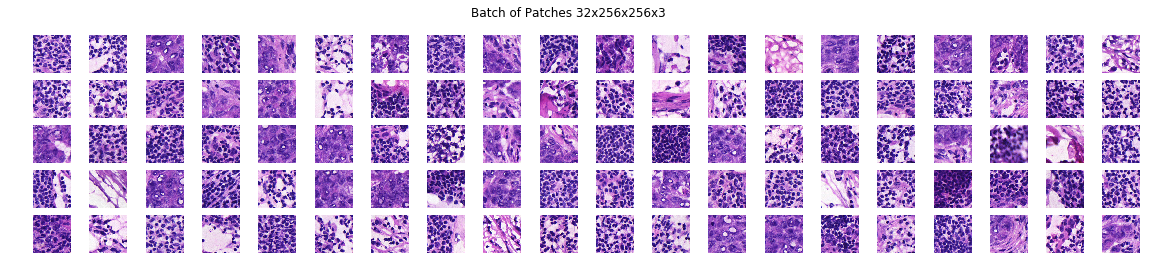

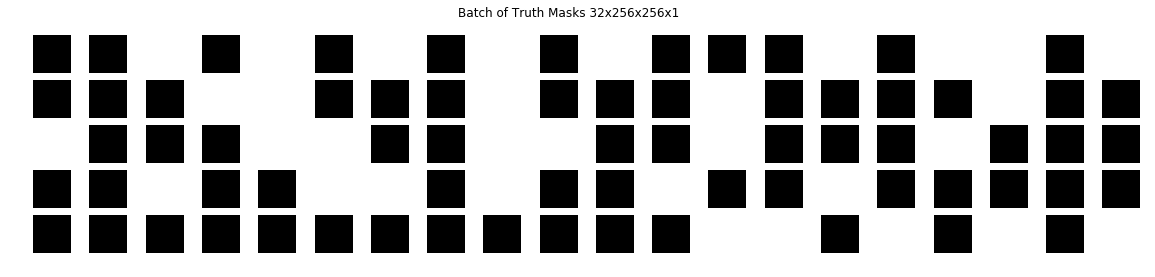

In [20]:
f, axes = plt.subplots(5, 20, figsize=(20, 4));
ax = axes.flatten()
for i in range(0, train_x.shape[0]):
    _ = ax[i].imshow(train_x[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(5, 20, figsize=(20, 4));
ax = axes.flatten()    
for i in range(0, train_x.shape[0]):
    _ = ax[i].imshow(train_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');

### 2) Create Generator

In [22]:
def train_generator(samples,
                    slide_path,
                    truth_path,
                    batch_size,
                    patch_size=256,
                    shuffle=True):
    '''The generator for Trainset
        Args:
            - samples: DataFrame of samples
            - slide_path: path of slide 
            - truth_path: path of truth(mask)
            - batch_size: mini-batch size
            - patch_size: patch size for samples
            - shuffle: bool, if True shuffle samples
        Returns(yield):
            - train_x: train dataset → [batch_size, patch_size, patch_size, 3]
            - train_y: train labelset → [batch_size, patch_size, patch_size, 2]
    '''
    
    slide = openslide.open_slide(slide_path)

    # tiles
    tiles = DeepZoomGenerator(slide, tile_size=patch_size, 
                              overlap=0, limit_bounds=False)

    start_x = int(slide.properties.get('openslide.bounds-x', 0)) / patch_size
    start_y = int(slide.properties.get('openslide.bounds-y', 0)) / patch_size
    
    num_samples = len(samples)
    slide_contains_tumor = 'pos' in slide_path
    if slide_contains_tumor:
        truth = openslide.open_slide(truth_path)
        truth_tiles = DeepZoomGenerator(truth, tile_size=16,  # tile_size=16인 이유는 mask가 원본의 1/16이어서 그런가?
                                        overlap=0, limit_bounds=False)

    while True:
        if shuffle:
            samples = samples.sample(frac=1)  # shuffling

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]

            batch_tiles, batch_masks = [], []
            for y, x in batch_samples['tile_loc'].values:
                img = tiles.get_tile(tiles.level_count-1, (x+start_x, y+start_y))
                batch_tiles.append(np.array(img, dtype=int))

                mask_tile = truth_tiles.get_tile(truth_tiles.level_count-1, (x, y))
                mask_tile = cv2.cvtColor(np.array(mask_tile), cv2.COLOR_RGB2GRAY)
                mask_tile_zoom = cv2.resize(mask_tile, (patch_size, patch_size), 
                                            interpolation=cv2.INTER_LINEAR)
                mask_tile_zoom = mask_tile_zoom.astype(int) / 255
                batch_masks.append(mask_tile_zoom)
                
        # train_x & train_y
        train_x = np.array(batch_tiles) / 255.
        train_y = to_categorical(np.array(batch_masks), num_classes=2)
        yield train_x, train_y

In [25]:
%%time
# Set Params
patch_size = 256
batch_size = 100
shuffle = False
samples = all_tissue_samples.sample(1000, random_state=13)
# slide path & mask path
slide_path = '../data/train/pos/16-S-042893_A1.mrxs'  # pos
truth_path = '../data/train/pos/Mask_16-S-042893_A1.png'  # pos

# call the generator
data_gen = train_generator(samples, slide_path, truth_path,
                           batch_size, patch_size, shuffle)

train_x, train_y = next(data_gen)

CPU times: user 3.55 s, sys: 144 ms, total: 3.69 s
Wall time: 3.7 s


In [26]:
print('train_x.shape :', train_x.shape)
print('train_y.shape :', train_y.shape)

train_x.shape : (100, 256, 256, 3)
train_y.shape : (100, 256, 256, 2)


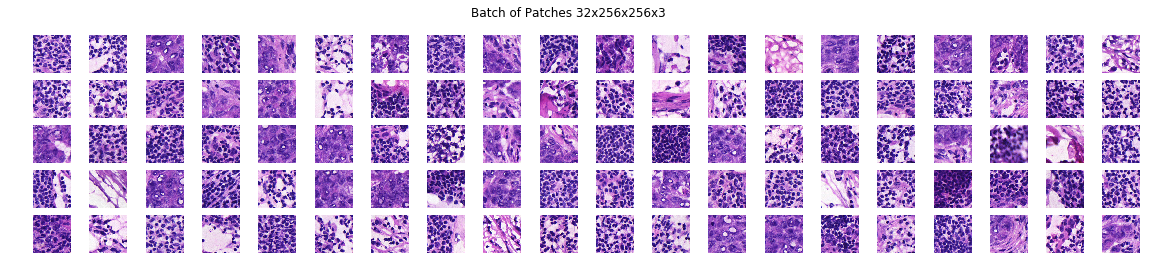

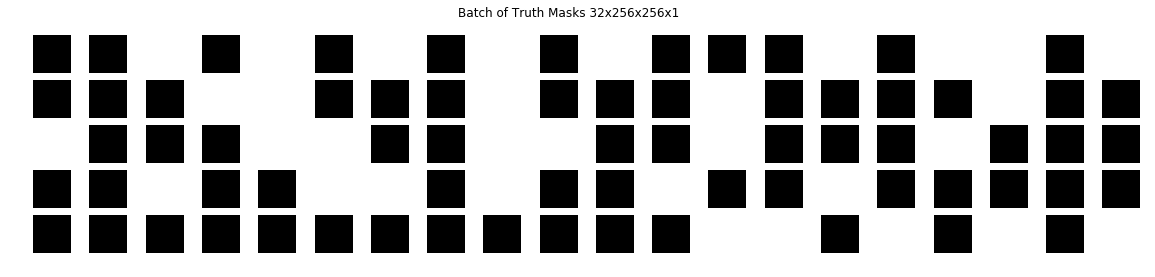

In [28]:
f, axes = plt.subplots(5, 20, figsize=(20, 4));
ax = axes.flatten()
for i in range(0, train_x.shape[0]):
    _ = ax[i].imshow(train_x[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(5, 20, figsize=(20, 4));
ax = axes.flatten()    
for i in range(0, train_x.shape[0]):
    _ = ax[i].imshow(train_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');